# Guess the movie!
<img src=when-harry-met-sally.jpg>

# Guess the movie!

<img src=royal.png>

# Guess the movie!
<img src=godfather.jpg>

# Films Shot in NYC


<img src=anniehall.jpg>
<img src=dark.jpg>

# Questions
## what are the most popular locations?
## trend of locations over time?
## what movie had the most locations?
## average locations per movie?
## what borough had most locations?

# Outline:
## - Scraped website
## - Questions about the data
## - Exploration
## - Points for future analysis

# Scraped Website
<img src="otsonylogo_2015.jpg">

- website containing over 1,100 movies that were filmed in New York
- photos and addresses of different movie scenes

<img src='otso_1.png'>

<img src='otso_2.png'>

<img src='otso_3.png'>

# Questions about the data
- what movie had the most filmed locations?
- what did the number of filmed locations look like over time?

### Outline
- motivation: favorite movies in NYC
- movies stats, based on film permit data from Mayor's Office of Film: about 17,241 movie scenes filmed between 2011 and 2013
- otsoNY: contains over 1,100 movies that were filmed in NYC
- otsoNY website tour
- questions to answer
- exploration
- where were your favorite movies shot?
- given more time:
    - get a complete list of geocodes for all locations
    - plot all locations on a map
    - arrange by year, genre
    - what were the most popular locations


In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import sqlite3
import re
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/tocruz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# create Mongo Client to retrieve collections 

client = MongoClient('localhost', 27017)
db = client.nyc_movies_location
movies_df = pd.DataFrame(list(db.location.find()))



In [4]:
movies_df.head()

,_id,location,title
0,5740f84bb104ca565618e27d,[Fulton Ferry Pier (Near Brooklyn Bridge) Broo...,Absolute Trust (2009)
1,5740f84eb104ca565618e27e,[Tavern on the Green (btw West 66th and 67th S...,Arthur 2: On the Rocks (1988)
2,5740f850b104ca565618e27f,"[The Plaza Hotel, 750 5th Avenue and Central P...",Arthur (1981)
3,5740f853b104ca565618e280,"[The Flatiron Building, 175 5th Avenue, Manhat...",Armageddon (1998)
4,5740f857b104ca565618e281,"[Robert's Apartment, 19 Gramercy Park & East 2...",Arbitrage (2012)


In [5]:
movies_df.describe()

,_id,location,title
count,1171,1171,1171
unique,1171,1106,1157
top,57410879b104ca565618e6cd,"[Times Square, Manhattan.]",Spread (2009)
freq,1,15,14


# Get year of each movie

In [6]:
# Get year of each movie

temp_year = [str(re.findall('\((\d+)\)',x)).strip('[]') for x in \
             movies_df['title']]
movies_df['year'] = temp_year
movies_df.tail()

,_id,location,title,year
1166,574109c2b104ca565618e70b,"[Katz's Delicatessen, 205 East Houston Street ...",Across the Universe (2007),u'2007'
1167,574109c6b104ca565618e70c,"[West 110th Street and Malcolm X Boulevard, Ma...",Across 110th Street (1972),u'1972'
1168,574109cab104ca565618e70d,"[Times Square, Manhattan., Mark Hellinger Thea...",A Chorus Line (1985),u'1985'
1169,574109ceb104ca565618e70e,"[New York County Supreme Court, 60 Centre Stre...",The Accidental Husband (2008),u'2008'
1170,574109d2b104ca565618e70f,"[Elmer Holmes Bobst Library, 70 Washington Squ...",The Addiction (1995),u'1995'


# Get locations per movie

In [7]:
# length of locations list
len(movies_df.location[0])

2

In [8]:
movies_df['location'][0]

[u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.',
 u'Ground Zero, Greenwich Street and Liberty Street, Manhattan.']

In [9]:
movies_df['location'].apply(len).max()

39

In [10]:
# movie with most locations
movies_df[movies_df['location'].apply(len) == 39]

,_id,location,title,year
262,5740fc21b104ca565618e383,"[5th Avenue and East 57th Street, Manhattan., ...",Sex and the City (2008),u'2008'


## Create empty data frame

In [11]:
# empty data frame with 1171 rows and 39 columns
columns = []
for i in range(1,40):
    columns.append('location_'+str(i))
columns[:5]

['location_1', 'location_2', 'location_3', 'location_4', 'location_5']

In [12]:
locations2_df = pd.DataFrame(index = range(len(movies_df)+1),\
                           columns = columns)
locations2_df.head()

,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,...,location_30,location_31,location_32,location_33,location_34,location_35,location_36,location_37,location_38,location_39
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len(movies_df)

1171

## Create data frame for movie and location

In [14]:
# dataframe where one row contains a movie title and a location
locations_list = []
for i in range(len(movies_df)):
    for j in movies_df.location[i]:
        locations_list.append((movies_df.title[i], j))

In [15]:
locations_list[0]

(u'Absolute Trust (2009)',
 u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.')

In [16]:
columns = ('movie', 'location')
locations_df = pd.DataFrame(locations_list, columns = columns)
locations_df.head()

,movie,location
0,Absolute Trust (2009),Fulton Ferry Pier (Near Brooklyn Bridge) Brook...
1,Absolute Trust (2009),"Ground Zero, Greenwich Street and Liberty Stre..."
2,Arthur 2: On the Rocks (1988),Tavern on the Green (btw West 66th and 67th St...
3,Arthur 2: On the Rocks (1988),"Arthur's Apartment, 676 Park Avenue and East 6..."
4,Arthur 2: On the Rocks (1988),"Sutton Square and Sutton Place, Manhattan."


## Write to csv (testing)

In [17]:
locations_df.to_csv('test_locations.csv', columns = ('movie','location'),\
                   encoding = 'utf8')

## Obtain geocodes per location address

In [18]:
locations_df.location[0]

u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.'

In [19]:
geocoder.google(locations_df.location[0])

<[OK] Google - Geocode [Brooklyn Bridge Park Pier 6, Pier 6 - Governors Island, Brooklyn, NY 11201, USA]>

In [20]:
geocodes_list = []
i = 0
for i in locations_df.location:
    geocodes_list.append(geocoder.google(i).latlng)

Traceback (most recent call last):
  File "/Users/tocruz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/tocruz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/Users/tocruz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/tocruz/anaconda/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/tocruz/anaconda/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/tocruz/anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [21]:
len(geocodes_list)

33

In [ ]:
pd.DataFrame(geocodes_list, columns = ('latitude', 'longitude'))[:5]

In [ ]:
geolocator = Nominatim()
location = geolocator.geocode(locations_df.location[1])

In [ ]:
pd.concat([locations_df[:5231], pd.DataFrame(geocodes_list, columns = ('latitude', 'longitude'))], axis = 1)

In [ ]:
latlong_df = pd.concat([locations_df[:5231], pd.DataFrame(geocodes_list, columns = ('latitude', 'longitude'))], axis = 1)
latlong_df.head()

In [ ]:
latlong_df.to_csv('lat_long.csv', columns = ('movie','location', 'lat','long'),\
                   encoding = 'utf8')

## Locations over time

In [27]:
loc_count = movies_df.groupby('year').count()[1:-1]
loc_count
# drop 2016

,_id,location,title,total_loc
year,,,,
u'1927',1,1,1,1
u'1928',1,1,1,1
u'1933',2,2,2,2
u'1937',1,1,1,1
u'1942',3,3,3,3
u'1945',5,5,5,5
u'1947',5,5,5,5
u'1948',5,5,5,5
u'1949',3,3,3,3


In [23]:
# top 10 movies by location
movies_df['total_loc'] = movies_df['location'].apply(len)
movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,title,total_loc
262,Sex and the City (2008),39
355,Premium Rush (2012),37
444,Nine 1/2 Weeks (1986),25
928,The Devil Wears Prada (2006),23
419,One Fine Day (1996),23
17,You've Got Mail (1998),23
578,Lola Versus (2012),22
1161,The Adjustment Bureau (2011),22
931,Desperately Seeking Susan (1985),21
463,New Year's Eve (2011),21


In [24]:
np.arange(len(movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]['title']))

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


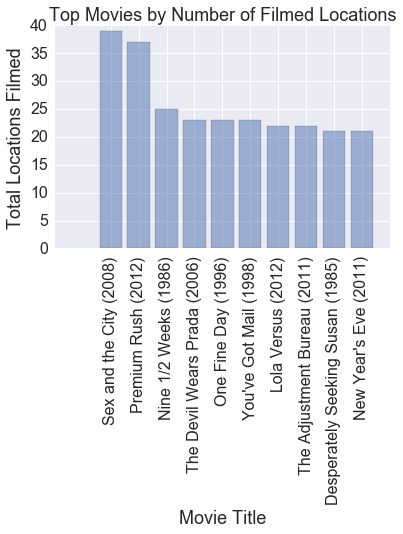

In [29]:
x_axis = movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]['title']
y_axis = movies_df[['title','total_loc']].sort('total_loc',\
        ascending=False)[:10]['total_loc']
pos = np.arange(len(x_axis))

plt.bar(pos, y_axis, align='center', alpha=0.5)
plt.xticks(pos, x_axis, rotation = 'vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.title('Top Movies by Number of Filmed Locations',\
         fontsize = 18)
plt.xlabel('Movie Title', fontsize = 18)
plt.ylabel('Total Locations Filmed', fontsize = 18)

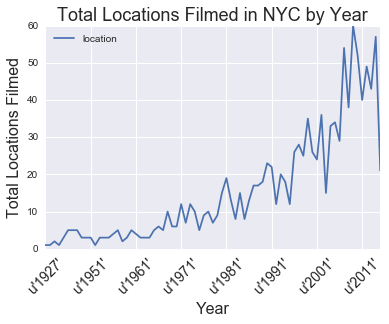

In [28]:
loc_count[['location']].plot()
plt.title('Total Locations Filmed in NYC by Year', fontsize = 18)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.ylabel('Total Locations Filmed', fontsize=16)

<img src='tableau.png'>

# Points for Future Analysis
# - complete batch geocoding
# - plot all film locations on a map
# - arrange by year, genre
# - what were the most popular locations

